In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist
from art.attacks.evasion.projected_gradient_descent import ProjectedGradientDescent

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128) 

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

In [9]:
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/MNIST/Carlini/Adversarial PGD")
file = "model_01.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

# Model

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
    
    activations_fc2, activations_fc1 = [], []
    mask_fc2, mask_fc1 = torch.zeros(1, 200), torch.zeros(1, 512)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        self.activations_fc1.append(x)
        x = F.relu(self.fc2(x))
        self.activations_fc2.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))*self.mask_fc1
        x = F.relu(self.fc2(x))*self.mask_fc2
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 97.05 %


# MaskModel

In [11]:
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
    
    mask_fc2, mask_fc1, mask_conv = torch.ones(1, 200), torch.ones(1, 512), torch.ones(320)
        
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))*self.mask_fc1.to(device)
        x = F.relu(self.fc2(x))*self.mask_fc2.to(device)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
mask_model = MaskModel().to(device)

# Load pre-trained model
mask_model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(mask_model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mask_model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=mask_model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = mask_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 97.05 %


## Pruning

In [12]:
model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))

activations_fc2 = model.activations_fc2
activations_fc1 = model.activations_fc1

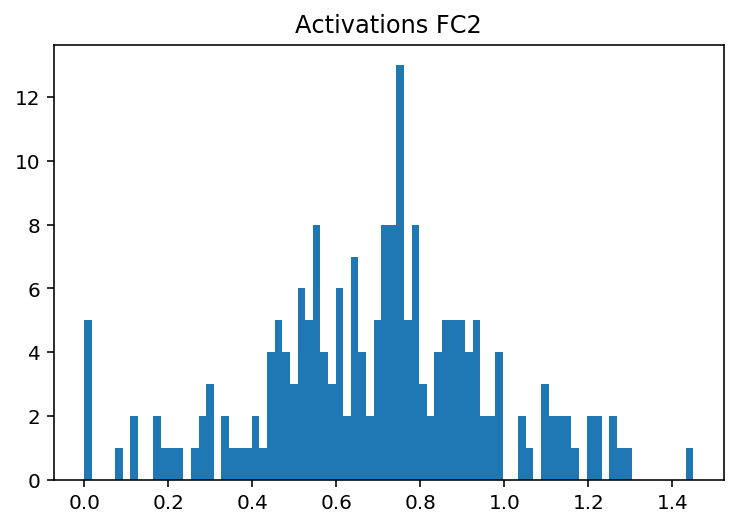

In [13]:
n = len(activations_fc2)
element0 = activations_fc2.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc2.pop()
    act[e+1,:,:] = elementX

mean_activations_fc2 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc2.numpy()
plt.hist(ma,80)
plt.title('Activations FC2')
plt.show()

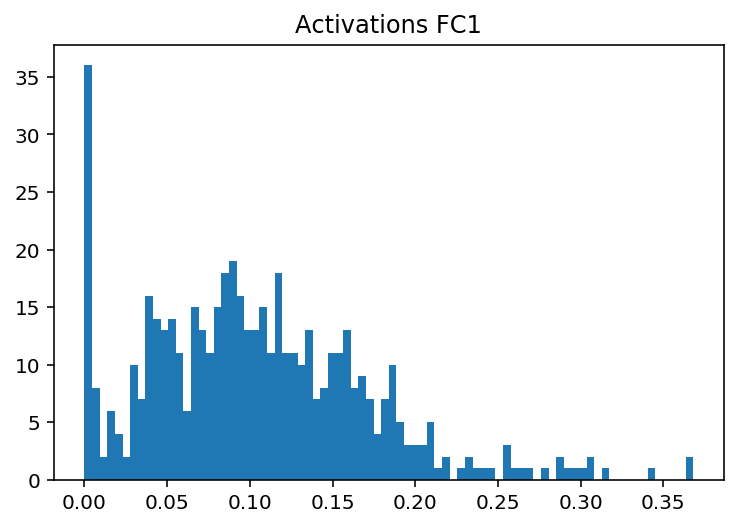

In [14]:
n = len(activations_fc1)
element0 = activations_fc1.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations_fc1.pop()
    act[e+1,:,:] = elementX

mean_activations_fc1 = torch.mean(act,dim=[0,1])
ma = mean_activations_fc1.numpy()
plt.hist(ma,80)
plt.title('Activations FC1')
plt.show()

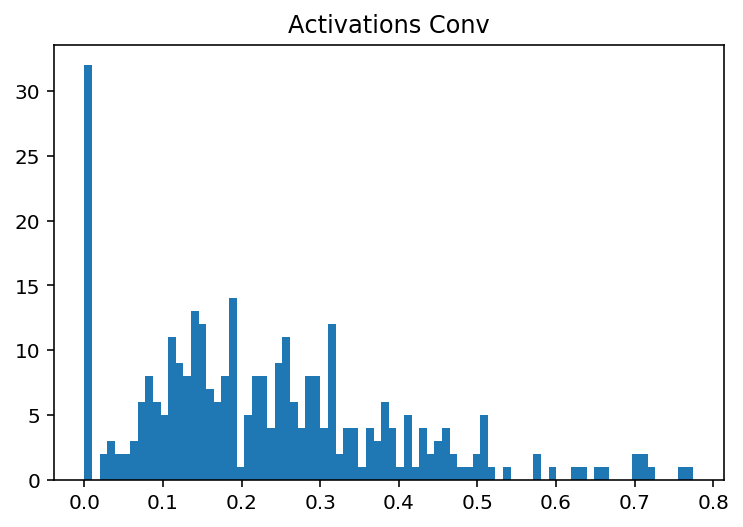

In [9]:
# n = len(activations_conv)
# element0 = activations_conv.pop()
# act = torch.zeros(n,element0.size(0),element0.size(1))
# act[0,:,:] = element0

# for e in range(n-1):
#     elementX = activations_conv.pop()
#     act[e+1,:,:] = elementX

# mean_activations_conv = torch.mean(act,dim=[0,1])
# ma = mean_activations_conv.numpy()
# plt.hist(ma,80)
# plt.title('Activations Conv')
# plt.show()

In [19]:
# save different masks for different percentages

masks_fc2 = dict()
masks_fc1 = dict()
masks_conv = dict()

for percentage in range(9): 
#     FC2
    s_ma_fc2, idx_ma_fc2 = torch.sort(mean_activations_fc2)
    m_fc2 = torch.ones(mean_activations_fc2.size()).to(device)
    nn_fc2 = mean_activations_fc2.size(0)
    ind_r_fc2 = round((percentage/10)*nn_fc2)
    m_fc2[idx_ma_fc2[:ind_r_fc2]] = 0.0
    n1_fc2 = m_fc2.sum()
    model.mask_fc2 = m_fc2
    masks_fc2[percentage/10] = model.mask_fc2
    
#     FC1
    s_ma_fc1, idx_ma_fc1 = torch.sort(mean_activations_fc1)
    m_fc1 = torch.ones(mean_activations_fc1.size()).to(device)
    nn_fc1 = mean_activations_fc1.size(0)
    ind_r_fc1 = round((percentage/10)*nn_fc1)
    m_fc1[idx_ma_fc1[:ind_r_fc1]] = 0.0
    n1_fc1 = m_fc1.sum()
    model.mask_fc1 = m_fc1
    masks_fc1[percentage/10] = model.mask_fc1


#     Conv
#     s_ma_conv, idx_ma_conv = torch.sort(mean_activations_conv)
#     m_conv = torch.ones(mean_activations_conv.size()).to(device)
#     nn_conv = mean_activations_conv.size(0)
#     ind_r_conv = round((percentage/10)*nn_conv)
#     m_conv[idx_ma_conv[:ind_r_conv]] = 0.0
#     n1_conv = m_conv.sum()
#     model.mask_conv = m_conv
#     masks_conv[percentage/10] = model.mask_conv

In [20]:
# evaluate with the new masks
acc = []
for (pg, mask_fc2), (pg, mask_fc1) in zip(masks_fc2.items(), masks_fc1.items()):
    model.mask_fc2 = mask_fc2
    model.mask_fc1 = mask_fc1
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 97.05 %
Pruned 0.1  Accuracy: 97.03 %
Pruned 0.2  Accuracy: 96.91 %
Pruned 0.3  Accuracy: 96.78 %
Pruned 0.4  Accuracy: 96.39999999999999 %
Pruned 0.5  Accuracy: 95.76 %
Pruned 0.6  Accuracy: 95.54 %
Pruned 0.7  Accuracy: 93.36 %
Pruned 0.8  Accuracy: 81.12 %


# Carlini attack

In [21]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [22]:
carlini_prune = dict()
constants = [0.1, 1.0, 2.5, 5, 10, 15, 20, 25, 30, 40]

n = 1000

# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1) in zip(masks_fc2.items(), masks_fc1.items()):
    print('\n Pruned {}'.format(pg))
    accuracies, distances = [], []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results


 Pruned 0.0
c: 0.1  Accuracy: 0.955  Distance: 0.098
c: 1.0  Accuracy: 0.93  Distance: 0.564
c: 2.5  Accuracy: 0.874  Distance: 1.121
c: 5  Accuracy: 0.805  Distance: 1.725
c: 10  Accuracy: 0.67  Distance: 2.632
c: 15  Accuracy: 0.574  Distance: 3.122
c: 20  Accuracy: 0.521  Distance: 3.377
c: 25  Accuracy: 0.468  Distance: 3.592
c: 30  Accuracy: 0.443  Distance: 3.728
c: 40  Accuracy: 0.391  Distance: 3.967

 Pruned 0.1
c: 0.1  Accuracy: 0.952  Distance: 0.101
c: 1.0  Accuracy: 0.929  Distance: 0.569
c: 2.5  Accuracy: 0.881  Distance: 1.062
c: 5  Accuracy: 0.807  Distance: 1.657
c: 10  Accuracy: 0.689  Distance: 2.546
c: 15  Accuracy: 0.601  Distance: 2.963
c: 20  Accuracy: 0.538  Distance: 3.313
c: 25  Accuracy: 0.489  Distance: 3.5
c: 30  Accuracy: 0.466  Distance: 3.647
c: 40  Accuracy: 0.415  Distance: 3.877

 Pruned 0.2
c: 0.1  Accuracy: 0.952  Distance: 0.086
c: 1.0  Accuracy: 0.927  Distance: 0.559
c: 2.5  Accuracy: 0.886  Distance: 0.995
c: 5  Accuracy: 0.821  Distance: 1.532

In [23]:
carlini_inf_prune = dict()
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

n = 1000
# Run test for each c and mask PG 
for (pg, mask_fc2), (pg, mask_fc1) in zip(masks_fc2.items(), masks_fc1.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results


 Pruned 0.0
eps: 0.01  Accuracy: 0.956
eps: 0.1  Accuracy: 0.957
eps: 0.2  Accuracy: 0.913
eps: 0.3  Accuracy: 0.854
eps: 0.4  Accuracy: 0.752
eps: 0.5  Accuracy: 0.588
eps: 0.6  Accuracy: 0.412
eps: 0.7  Accuracy: 0.259
eps: 0.8  Accuracy: 0.26
eps: 0.9  Accuracy: 0.266
eps: 1  Accuracy: 0.277

 Pruned 0.1
eps: 0.01  Accuracy: 0.954
eps: 0.1  Accuracy: 0.954
eps: 0.2  Accuracy: 0.915
eps: 0.3  Accuracy: 0.856
eps: 0.4  Accuracy: 0.751
eps: 0.5  Accuracy: 0.602
eps: 0.6  Accuracy: 0.44
eps: 0.7  Accuracy: 0.267
eps: 0.8  Accuracy: 0.277
eps: 0.9  Accuracy: 0.271
eps: 1  Accuracy: 0.266

 Pruned 0.2
eps: 0.01  Accuracy: 0.963
eps: 0.1  Accuracy: 0.953
eps: 0.2  Accuracy: 0.913
eps: 0.3  Accuracy: 0.846
eps: 0.4  Accuracy: 0.744
eps: 0.5  Accuracy: 0.597
eps: 0.6  Accuracy: 0.437
eps: 0.7  Accuracy: 0.265
eps: 0.8  Accuracy: 0.266
eps: 0.9  Accuracy: 0.257
eps: 1  Accuracy: 0.261

 Pruned 0.3
eps: 0.01  Accuracy: 0.955
eps: 0.1  Accuracy: 0.946
eps: 0.2  Accuracy: 0.904
eps: 0.3  Accura

# FGSM attack

In [45]:
fgsm_prune = dict()
n = 1000

# Run test for each epsilon and mask PG 
for (pg, mask_fc2), (pg, mask_fc1), (pg, mask_conv) in zip(masks_fc2.items(), masks_fc1.items(), masks_conv.items()):
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    mask_model.mask_fc2 = mask_fc2
    mask_model.mask_fc1 = mask_fc1
    mask_model.mask_conv = mask_conv
    
    for e in epsilons:
        adv_crafter = FastGradientMethod(mask_classifier, eps=e)
        x_test_adv = adv_crafter.generate(x=x_test[:n])
        predictions = mask_classifier.predict(x_test_adv)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(accuracy)
        print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    fgsm_prune[pg] = results


 Pruned 0.0
Epsilon: 0.01   Test Accuracy = 0.956
Epsilon: 0.1   Test Accuracy = 0.955
Epsilon: 0.2   Test Accuracy = 0.932
Epsilon: 0.3   Test Accuracy = 0.899
Epsilon: 0.4   Test Accuracy = 0.731
Epsilon: 0.5   Test Accuracy = 0.326
Epsilon: 0.6   Test Accuracy = 0.165

 Pruned 0.1
Epsilon: 0.01   Test Accuracy = 0.954
Epsilon: 0.1   Test Accuracy = 0.954
Epsilon: 0.2   Test Accuracy = 0.928
Epsilon: 0.3   Test Accuracy = 0.899
Epsilon: 0.4   Test Accuracy = 0.728
Epsilon: 0.5   Test Accuracy = 0.327
Epsilon: 0.6   Test Accuracy = 0.172

 Pruned 0.2
Epsilon: 0.01   Test Accuracy = 0.95
Epsilon: 0.1   Test Accuracy = 0.948
Epsilon: 0.2   Test Accuracy = 0.937
Epsilon: 0.3   Test Accuracy = 0.904
Epsilon: 0.4   Test Accuracy = 0.706
Epsilon: 0.5   Test Accuracy = 0.311
Epsilon: 0.6   Test Accuracy = 0.183

 Pruned 0.3
Epsilon: 0.01   Test Accuracy = 0.939
Epsilon: 0.1   Test Accuracy = 0.927
Epsilon: 0.2   Test Accuracy = 0.897
Epsilon: 0.3   Test Accuracy = 0.849
Epsilon: 0.4   Test 

# Results

### Carlini L2

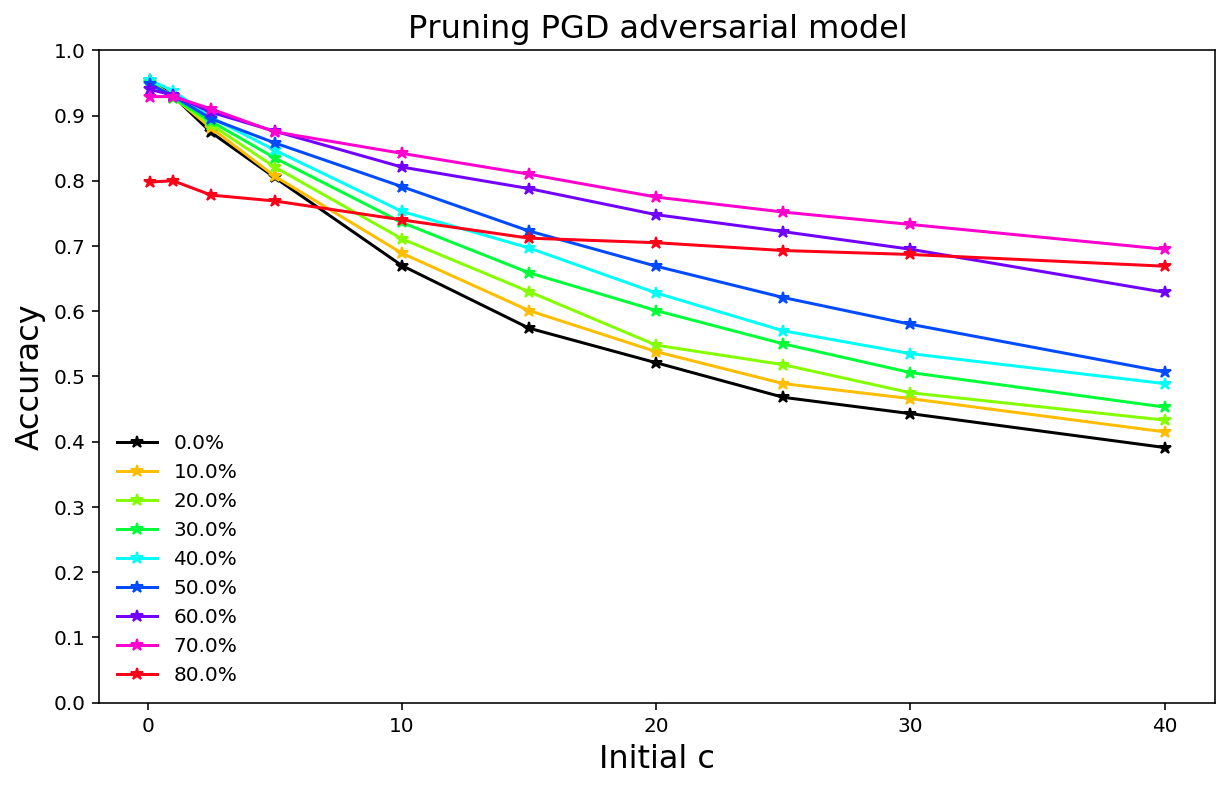

In [24]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 40.5, step=10))
plt.title("Pruning PGD adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

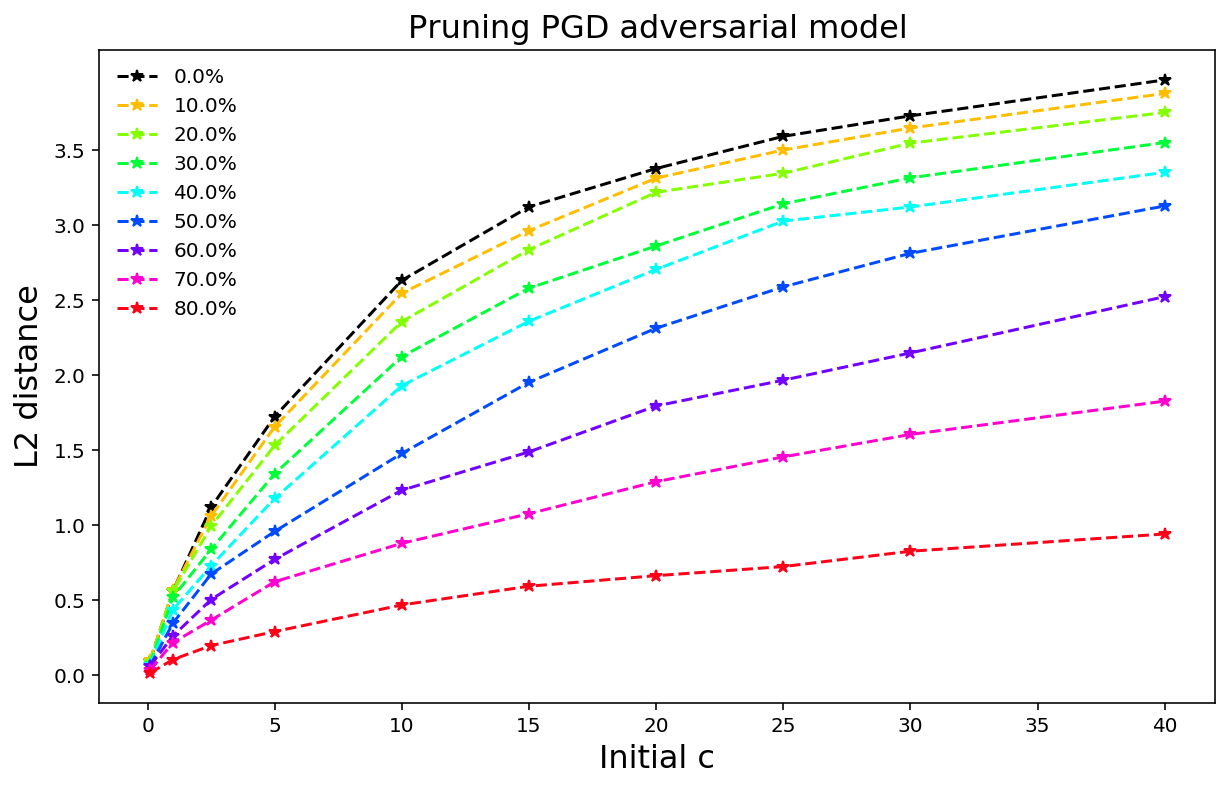

In [26]:
# plot the pruned distance vs initial c

plt.figure(figsize=(10,6))
# colors
n = len(carlini_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_prune.items()):
    plt.plot(results['constants'], results['distances'], "*--", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 3.6, step=0.5))
# plt.xticks(np.arange(0, 10.5, step=1))
plt.title("Pruning PGD adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Carlini Linf

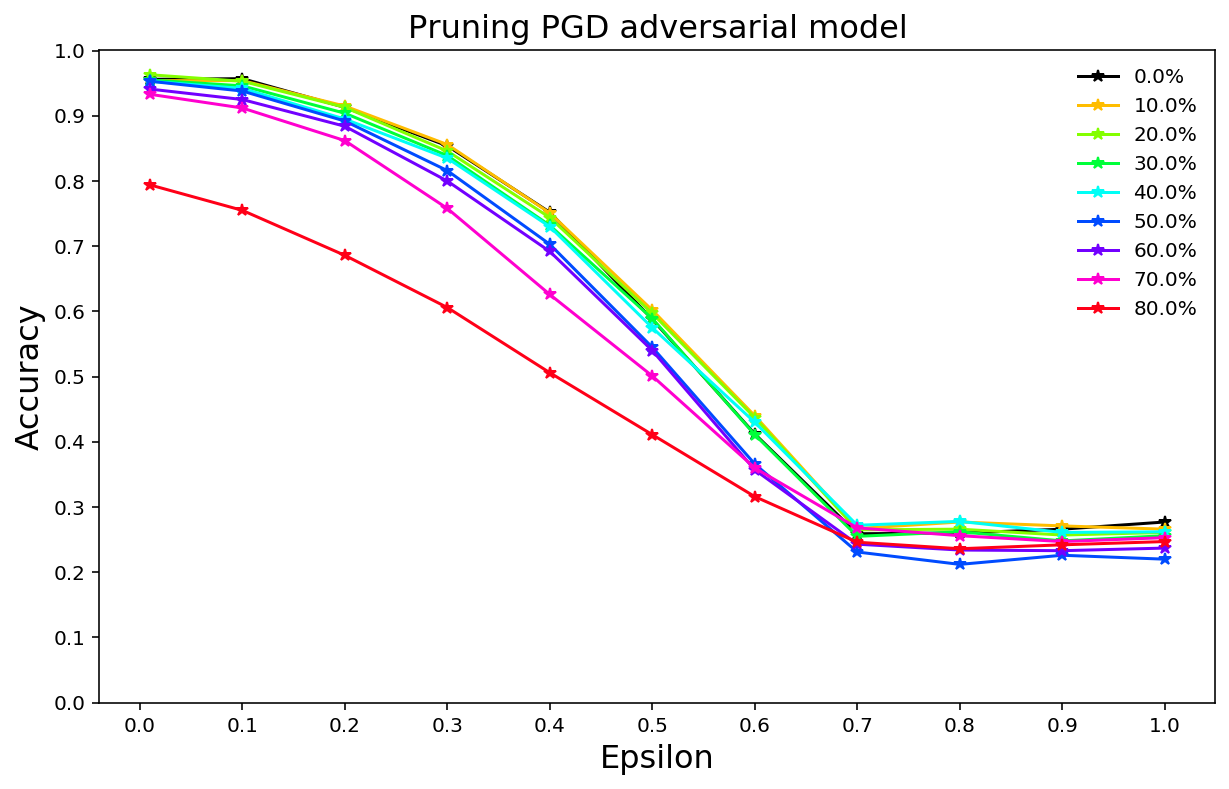

In [27]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
# colors
n = len(carlini_inf_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,1] 

for idx, (pg, results) in enumerate(carlini_inf_prune.items()):
    plt.plot(results['epsilons'], results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("Pruning PGD adversarial model",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### FGSM

In [49]:
fgsm_prune[0.0]

{'accuracies': [0.956, 0.955, 0.932, 0.899, 0.731, 0.326, 0.165],
 'epsilons': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}

In [50]:
data = {
    'Baseline model': [0.985, 0.824, 0.376, 0.108, 0.027, 0.012, 0.011],
    'FGSM adversarial training': [0.959, 0.948, 0.914, 0.851, 0.691, 0.384, 0.163],
    'PGD adversarial training': [0.956, 0.955, 0.932, 0.899, 0.731, 0.326, 0.165]
}

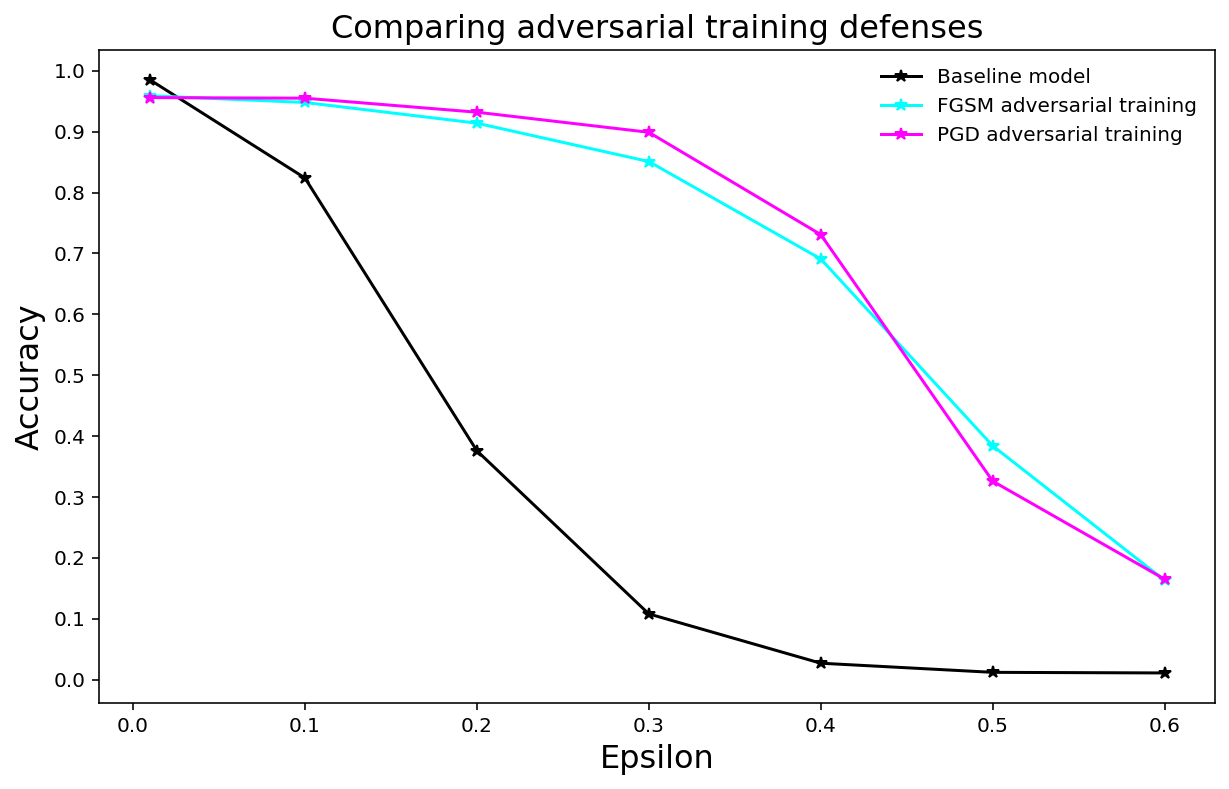

In [51]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

# colors
colors = ['black', 'cyan', 'fuchsia']

for idx, (title, results) in enumerate(data.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=title)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .65, step=0.1))
plt.title("Comparing adversarial training defenses",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

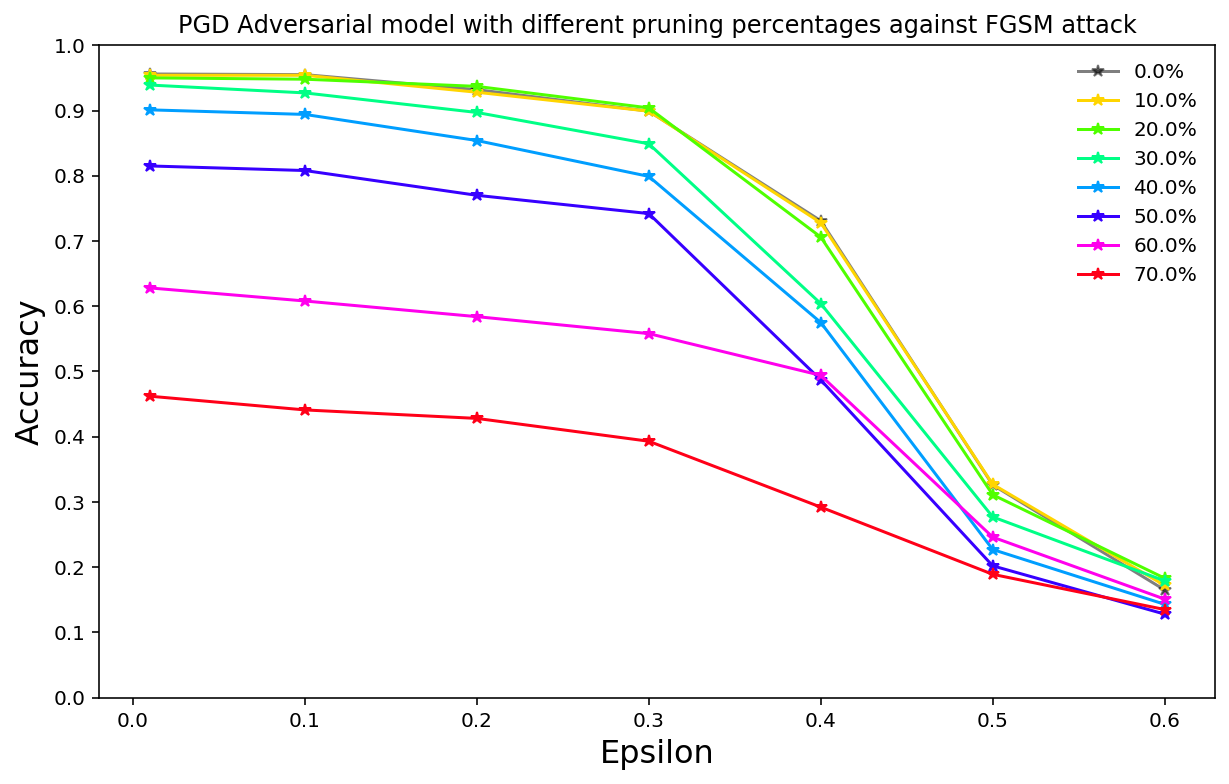

In [48]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

# colors
n = len(fgsm_prune)
colors = pl.cm.hsv(np.linspace(0,1,n))
colors[0]=[0,0,0,0.5] #half-black

for idx, (pg, results) in enumerate(fgsm_prune.items()):
    plt.plot(epsilons, results['accuracies'], "*-", color=colors[idx], label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .65, step=0.1))
plt.title("PGD Adversarial model with different pruning percentages against FGSM attack")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()